# Surfs Up!

## by Eric Hagee

This notebook simulates climate analysis of Honolulu, HI to plan a trip.  The sqlalchemy library in Python is used to simulate the access of a database of Honolulu, HI weather.

### Dependencies

First, we need to load appropriate dependencies.

For example, we will use numpy for appropriate numeric methods, pandas for dataframes, and matplotlib.pyplot for plotting.  We will use a color scheme based off that of FiveThirtyEight.com.

In [1]:
#set plot style
from matplotlib import style
style.use('fivethirtyeight')

In [2]:
#import basic dependencies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as mdates

In [3]:
#import date formatting tools
import datetime

We also need to access our database with sqlalchemy, to essentially write SQL queries with Python.

In [4]:
#import sqlalchemy tools
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import func, create_engine, inspect

### Reflect Database Tables into SQLAlchemy ORM

We need to set up a connection to the database (hawaii.sqlite) to use SQLAlchemy.

In [5]:
#create an engine to connect to the database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

Now, we will reflect that database (set up the metadata of what tables we have).

In [6]:
#reflect database
Base = automap_base()
#reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
#view the available tables
Base.classes.keys()

['measurement', 'station']

### Inspect Tables

We note that we have two tables, measurement and station.  We will save classes of these to be able to reference the tables.  Presumably, these correspond to actual weather measurements and information about specific stations.

In [8]:
#save references
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
#inspect measurement schema
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#inspect station columns
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


So, we basically have one table that has observations about precipitation and temperature for various dates.  We also have a list of stations and their locations/elevations.

### Connect to Database

We now need to actually connect to the database.

In [11]:
#connect to database
session = Session(engine)

### Trip Dates

We need to pick trip dates.  We will use a January 2019 trip time, assuming that crowds will dip after the holiday season.  So, we will go on January 4, 2019 and return on January 18, 2019.

We will save these as date objects.

In [12]:
#save start date and end date
start_date = datetime.date(2019, 1, 4)
end_date = datetime.date(2019, 1, 18)

### Exploratory Analysis

We will do some basic exploratory analysis of the data first.

#### Precipitation Analysis

First, we will look at precipitation data for the last year.

As we don't know how dates are formatted, we will inspect them first.

In [13]:
#inspect how the dates are formatted
sample_dates = session.query(Measurement.date).limit(5).all()
for result in sample_dates:
    print(result)

('2010-01-01',)
('2010-01-02',)
('2010-01-03',)
('2010-01-04',)
('2010-01-06',)


In [14]:
#dates are formatted as YYYY-MM-DD
#we will get the maximum date after formatting the dates appropriately
#first is used as there are multiple measurements on the same day
max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
max_date[0][0]

'2017-08-23'

So, the database runs through August 23, 2017.  So, we need to find data from August 23, 2016 to August 23, 2017.

In our format, that is 2016-08-23 to 2017-08-23.

In [15]:
#access all precipitation data from the last year (as the end of the data is our endpoint, we only need one comparison)
precip_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).all()

In [16]:
#load as a dataframe
precip_df = pd.DataFrame(precip_data, columns = ['date', 'precipitation'])

#set index
precip_df.set_index('date', inplace = True)

#look at dataframe
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [17]:
#sort data frame
precip_df = precip_df.sort_values(by = 'date')
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


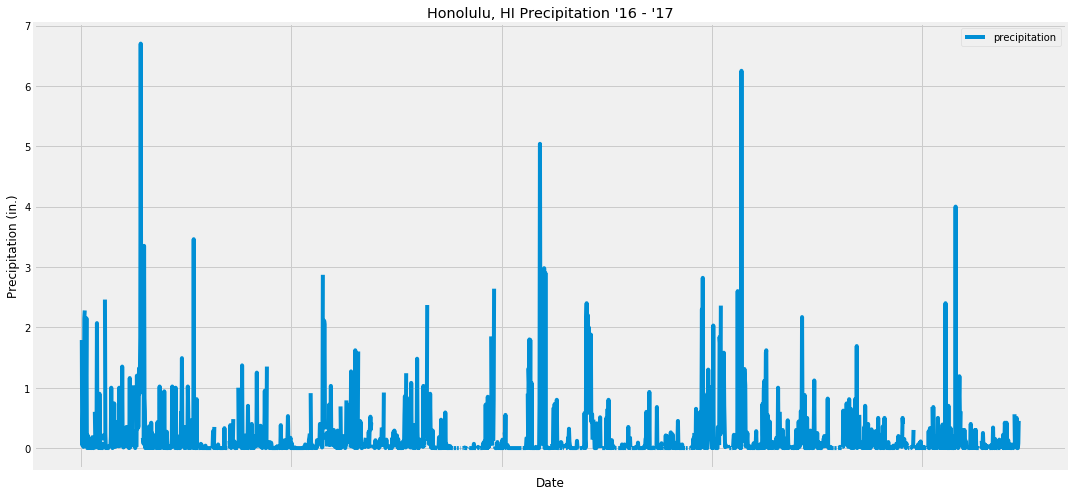

In [18]:
#plot data
fig, ax = plt.subplots(figsize = (15, 7))
precip_df.plot(ax = ax, x_compat = True)

#set title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Honolulu, HI Precipitation '16 - '17")

#save figure
plt.savefig("Images/precip.png")

#plot figure
plt.tight_layout()
plt.show()

Now, we wish to get a summary of the precipitation data.

In [19]:
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Apparently, it rains a fair bit on the occasions it does rain in Honolulu.  However, most observations are of very small precipitation amounts.

#### Station Analysis

We wish to investigate the actual stations themselves now.

First, we want to know how many stations there are.

In [20]:
#count distinct stations
num_of_stations = session.query(Station.id).distinct().count()
num_of_stations

9

Now, we wish to see which of the nine stations are the most active, so we will count the number of observations for each station.  To do this, we must join the tables.

In [21]:
station_counts = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

for result in station_counts:
    print(f"Station: {result[0]}\tCount: {result[1]}")

Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


We wish to now consider the temperature, and will use the most active station as a first check.  We will calculate the average, lowest, and highest temperature.

In [22]:
most_active_station = 'USC00519281'
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"Lowest Temperature: {summary_temps[0][0]} Fahrenheit")
print(f"Highest Temperature: {summary_temps[0][1]} Fahrenheit")
print(f"Average Temperature: {round(summary_temps[0][2], 2)} Fahrenheit")

Lowest Temperature: 54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


As well, we will find the temperatures for the final 12 months for the station with the most observations.

In [23]:
#get temperature data for most active station over final 12 months of data
yearly_temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).all()

#save as a data frame
yearly_temps_df = pd.DataFrame(yearly_temps, columns = ['date', 'temperature'])
yearly_temps_df.head()

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


Now, we want to plot the temperatures in a histogram.

In [24]:
#index by date
yearly_temps_df.set_index('date', inplace = True)

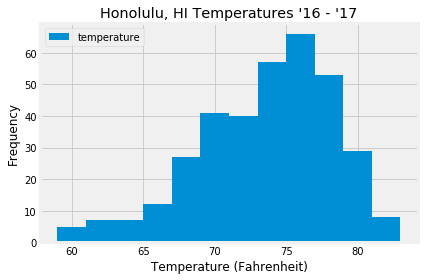

In [25]:
#plot histogram
fig, ax = plt.subplots()
yearly_temps_df.plot.hist(bins = 12, ax = ax)

#set labels
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')
ax.set_title("Honolulu, HI Temperatures '16 - '17")

#save figure
plt.savefig("Images/temphist.png")

#plot
plt.tight_layout()
plt.show()

We see the temperature is usually between 70 and 80 degrees Fahrenheit, which as it is Hawaii, is expected.

### Temperature Analysis for Trip

We wish to perform a temperature analysis for our trip dates January 4 to January 18.  As we only have data until 2017, we will query data for 2017-01-04 to 2017-01-18.

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
#Now, we can apply the function to our trip time.
trip_temps = calc_temps('2017-01-04', '2017-01-18')

print(f"Lowest Temperature: {trip_temps[0][0]} Fahrenheit")
print(f"Average Temperature: {round(trip_temps[0][1], 2)} Fahrenheit")
print(f"Highest Temperature: {trip_temps[0][2]} Fahrenheit")

Lowest Temperature: 60.0 Fahrenheit
Average Temperature: 69.26 Fahrenheit
Highest Temperature: 81.0 Fahrenheit


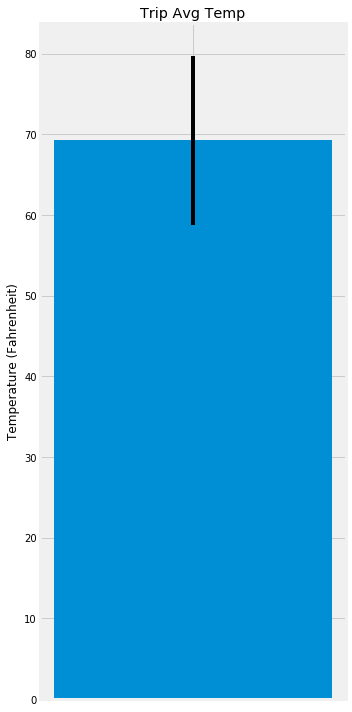

In [28]:
#Now, we plot the temperatures as a bar chart, where the average temp is the height and the peak to peak is the error
#bar (tmax - tmin)
pk_to_pk = trip_temps[0][2] - trip_temps[0][0]
avg_temp = trip_temps[0][1]

#plot figure
fig, ax = plt.subplots(figsize = (5, 10))

ax.bar(1, avg_temp, yerr = pk_to_pk/2, width = 0.4)

#set labels
ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temperature (Fahrenheit)')

#save fig
plt.savefig("Images/tempbar")

#show figure
plt.tight_layout()
plt.show()

### Rainfall per Weather Station

We wish to investigate the average rainfall at each station in the last year.

In [29]:
#get average rainfall for each weather station for the last year
yearly_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,
                               Station.elevation, func.avg(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).group_by(Station.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()

#load into a dataframe
yearly_rainfall_df = pd.DataFrame(yearly_rainfall, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Avg. Precipitation (in.)'])

yearly_rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation (in.)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.450640
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.198949
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141429
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.125434
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.121051
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.076500
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.044819


We see that some stations receive much more rainfall than others.

### Daily Normal Tempeartures for Trip

We wish to calculate the daily normal temperatures (historical averages for minimum, maximum, and mean temperatures) for our trip from Jan. 4 to Jan. 18.

In [30]:
#function to calculate daily normal temperature
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
#create a list of dates
trip_dates = ["01-04", "01-05", "01-06", "01-07", "01-08", "01-09", "01-10", "01-11", "01-12", "01-13", "01-14",
             "01-15", "01-16", "01-17", "01-18"]

In [32]:
#get daily normals
daily_norms = []

for trip_date in trip_dates:
    day = {}
    day['Date'] = f"2019-{trip_date}"
    daily_norm = daily_normals(trip_date)
    day['Min'] = daily_norm[0][0]
    day['Avg'] = daily_norm[0][1]
    day['Max'] = daily_norm[0][2]
    daily_norms.append(day)
    
daily_norms

[{'Date': '2019-01-04', 'Min': 58.0, 'Avg': 70.0, 'Max': 76.0},
 {'Date': '2019-01-05', 'Min': 56.0, 'Avg': 67.96428571428571, 'Max': 76.0},
 {'Date': '2019-01-06', 'Min': 61.0, 'Avg': 68.96491228070175, 'Max': 76.0},
 {'Date': '2019-01-07', 'Min': 57.0, 'Avg': 68.54385964912281, 'Max': 76.0},
 {'Date': '2019-01-08', 'Min': 57.0, 'Avg': 67.16071428571429, 'Max': 75.0},
 {'Date': '2019-01-09', 'Min': 58.0, 'Avg': 67.9298245614035, 'Max': 78.0},
 {'Date': '2019-01-10', 'Min': 62.0, 'Avg': 69.74137931034483, 'Max': 77.0},
 {'Date': '2019-01-11', 'Min': 57.0, 'Avg': 67.3103448275862, 'Max': 78.0},
 {'Date': '2019-01-12', 'Min': 57.0, 'Avg': 67.4074074074074, 'Max': 81.0},
 {'Date': '2019-01-13', 'Min': 57.0, 'Avg': 67.25454545454545, 'Max': 77.0},
 {'Date': '2019-01-14', 'Min': 58.0, 'Avg': 69.52631578947368, 'Max': 77.0},
 {'Date': '2019-01-15', 'Min': 56.0, 'Avg': 69.31372549019608, 'Max': 78.0},
 {'Date': '2019-01-16', 'Min': 54.0, 'Avg': 68.62962962962963, 'Max': 80.0},
 {'Date': '2019

In [33]:
#load into a data frame
daily_norms_df = pd.DataFrame(daily_norms)

#set index
daily_norms_df.set_index('Date', inplace = True)

#display
daily_norms_df

,Avg,Max,Min
Date,,,
2019-01-04,70.000000,76.0,58.0
2019-01-05,67.964286,76.0,56.0
2019-01-06,68.964912,76.0,61.0
2019-01-07,68.543860,76.0,57.0
2019-01-08,67.160714,75.0,57.0
2019-01-09,67.929825,78.0,58.0
2019-01-10,69.741379,77.0,62.0
2019-01-11,67.310345,78.0,57.0
2019-01-12,67.407407,81.0,57.0


We will now plot this as an area plot.

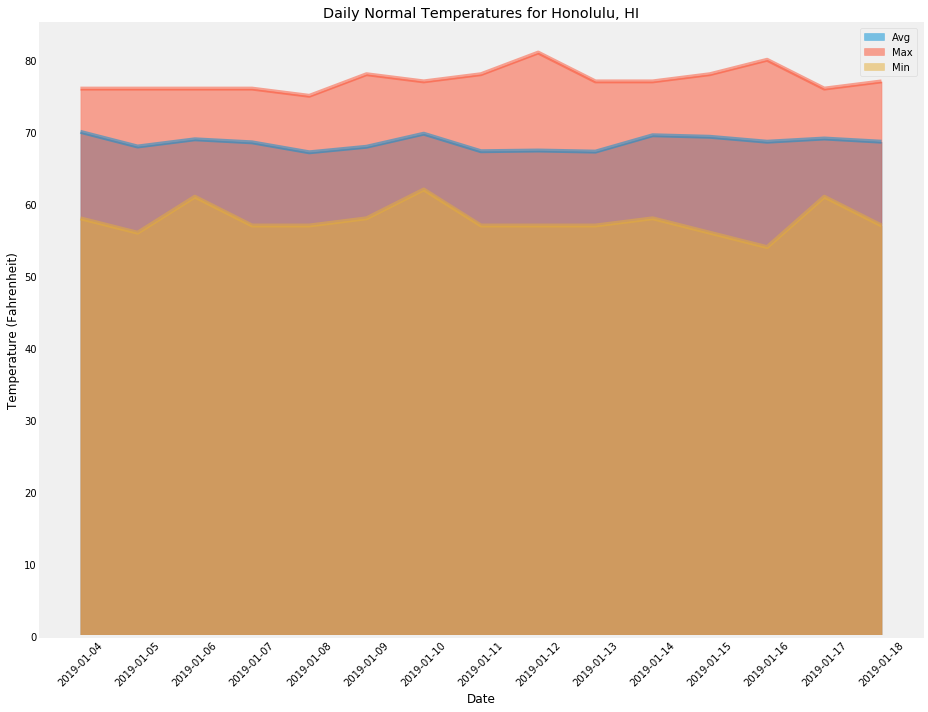

In [34]:
#plot
fig, ax = plt.subplots(figsize = (13, 10))
daily_norms_df.plot.area(ax = ax, stacked = False)

#set labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (Fahrenheit)')
ax.set_title('Daily Normal Temperatures for Honolulu, HI')

#set ticks
dates = [f"2019-{trip_date}" for trip_date in trip_dates]
ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation = 45)

#save figure
plt.savefig('Images/dailynormarea.png')

#show
plt.grid()
plt.tight_layout()
plt.show()